In [1]:
import os
import glob
import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

In [2]:
# Define paths
data_dir = "data"
subset_dirs = sorted(glob.glob(os.path.join(data_dir, "subset*/subset*")))
seg_dir = os.path.join(data_dir, "seg-lungs-LUNA16/seg-lungs-LUNA16")
annotations_file = os.path.join(data_dir, "annotations.csv")

print(f"Found {len(subset_dirs)} subset directories.")
print(f"Segmentation directory: {seg_dir}")
print(f"Annotations file: {annotations_file}")

Found 5 subset directories.
Segmentation directory: data/seg-lungs-LUNA16/seg-lungs-LUNA16
Annotations file: data/annotations.csv


In [3]:
df_ann = pd.read_csv(annotations_file)
print(f"Loaded annotations with {len(df_ann)} rows.")

# Count nodules per seriesuid
nodule_counts = df_ann['seriesuid'].value_counts()

Loaded annotations with 1186 rows.


In [ ]:
# Analyze Data
results = []
missing_masks_total = 0

all_nodule_counts = []
slice_counts_all = []

for subset_dir in subset_dirs:
    subset_name = os.path.basename(subset_dir)
    mhd_files = glob.glob(os.path.join(subset_dir, "*.mhd"))
    num_objects = len(mhd_files)
    
    print(f"\nProcessing {subset_name}: {num_objects} objects")
    
    missing_masks_subset = 0
    slice_counts_subset = []
    nodule_counts_subset = []
    
    for mhd_path in mhd_files:
        filename = os.path.basename(mhd_path)
        seriesuid = filename.replace(".mhd", "")
        
        # Check for segment mask
        mask_path = os.path.join(seg_dir, filename)
        if not os.path.exists(mask_path):
            missing_masks_subset += 1
            missing_masks_total += 1
            
        # Count slices
        image = sitk.ReadImage(mhd_path)
        # SimpleITK image size is (X, Y, Z), where Z is the number of slices.
        num_slices = image.GetSize()[2]
            
        slice_counts_subset.append(num_slices)
        slice_counts_all.append(num_slices)
    
            
        # Count nodules for this object
        count = nodule_counts.get(seriesuid, 0)
        nodule_counts_subset.append(count)
        all_nodule_counts.append(count)
        
    print(f"  Missing masks: {missing_masks_subset}")
    if slice_counts_subset:
        print(f"  Average slices: {sum(slice_counts_subset)/len(slice_counts_subset):.2f}")
    
    results.append({
        'subset': subset_name,
        'num_objects': num_objects,
        'missing_masks': missing_masks_subset,
        'nodule_counts': nodule_counts_subset
    })

print(f"\nTotal missing masks across all subsets: {missing_masks_total}")
print(f"Total objects processed: {len(all_nodule_counts)}")


Processing subset0: 89 objects
  Missing masks: 0
  Average slices: 256.97

Processing subset1: 89 objects
  Missing masks: 0
  Average slices: 243.28

Processing subset2: 89 objects
  Missing masks: 0
  Average slices: 278.17

Processing subset3: 89 objects
  Missing masks: 0
  Average slices: 268.61

Processing subset4: 89 objects
  Missing masks: 0
  Average slices: 262.99

Total missing masks across all subsets: 0
Total objects processed: 445


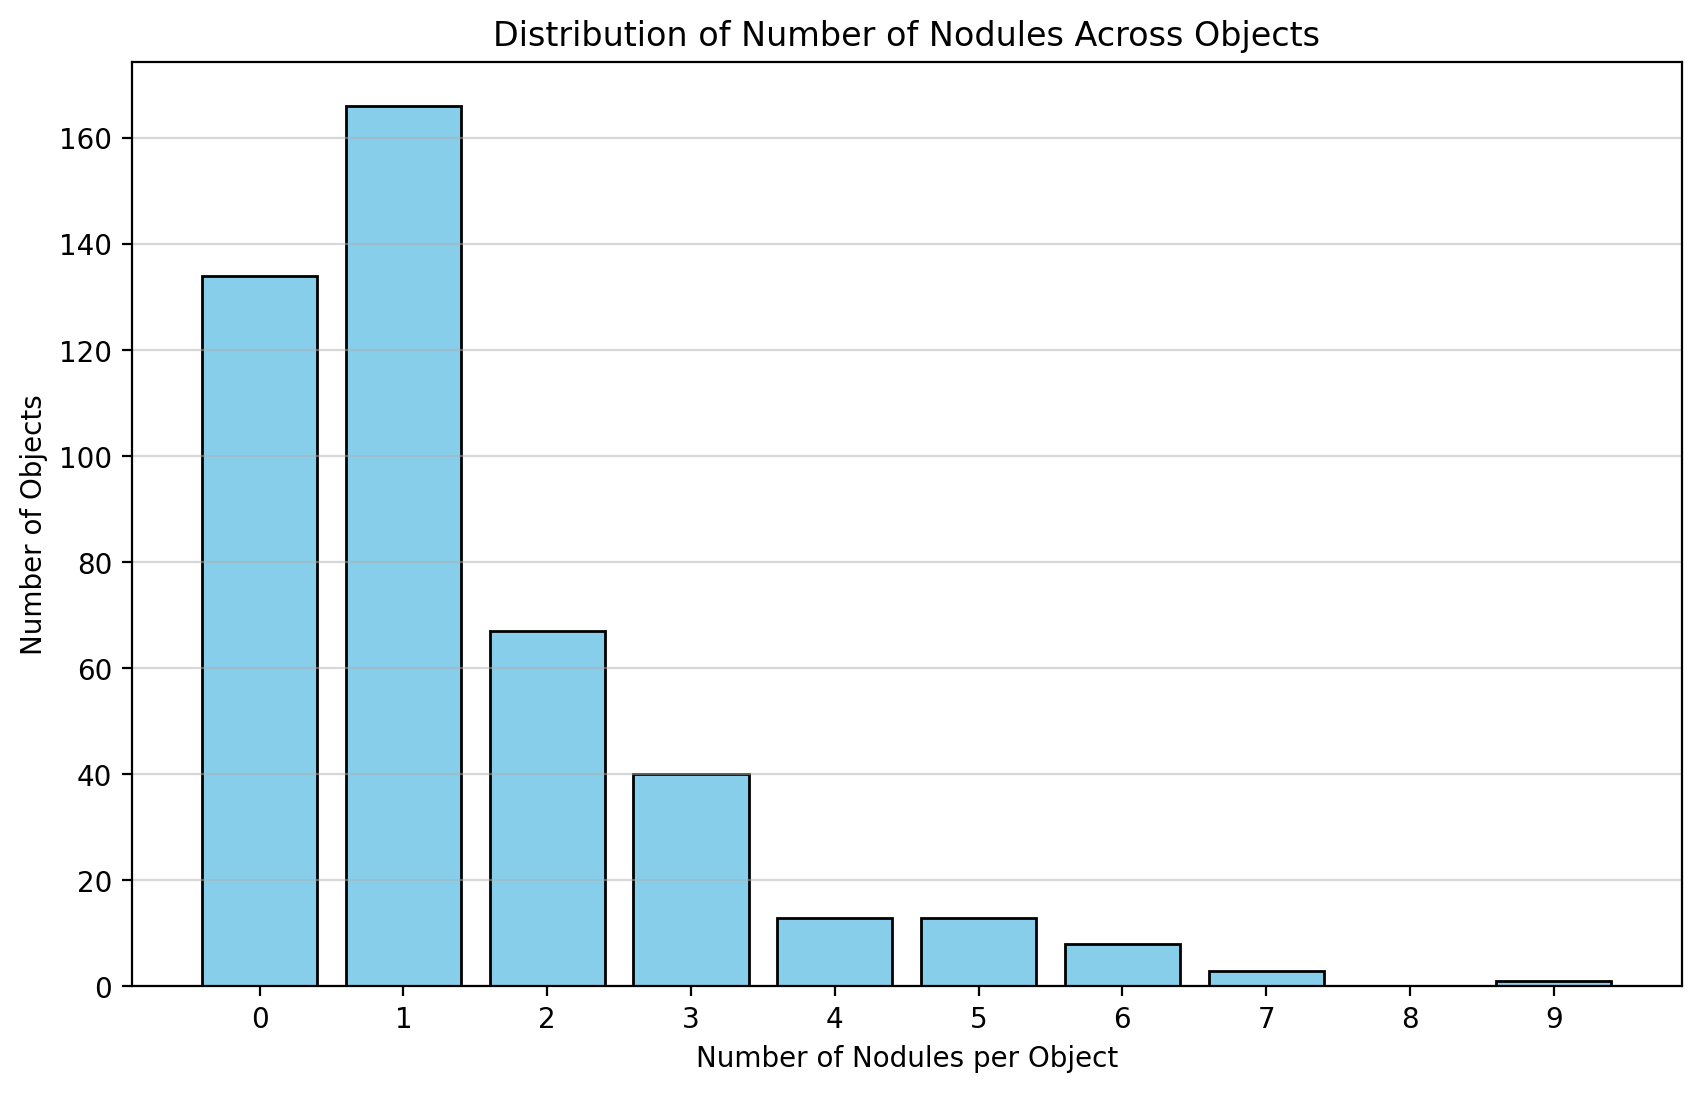

Nodule count distribution:
  0 nodules: 134 objects
  1 nodules: 166 objects
  2 nodules: 67 objects
  3 nodules: 40 objects
  4 nodules: 13 objects
  5 nodules: 13 objects
  6 nodules: 8 objects
  7 nodules: 3 objects
  9 nodules: 1 objects


In [8]:
# Plot Distribution of Number of Nodules
plt.figure(figsize=(10, 6), dpi=200)

max_nodules = max(all_nodule_counts)
bins = range(0, max_nodules + 2)
plt.hist(all_nodule_counts, bins=bins, align='left', rwidth=0.8, color='skyblue', edgecolor='black')
plt.xlabel('Number of Nodules per Object')
plt.ylabel('Number of Objects')
plt.title('Distribution of Number of Nodules Across Objects')
plt.xticks(bins[:-1])
plt.grid(axis='y', alpha=0.5)
plt.show()
    
counts = Counter(all_nodule_counts)
print("Nodule count distribution:")
for k in sorted(counts.keys()):
    print(f"  {k} nodules: {counts[k]} objects")